In [1]:
import os, sys
sys.path.append("../src")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,"
from pathlib import Path
from types import SimpleNamespace
from tqdm import tqdm
from datetime import datetime
from omegaconf import OmegaConf
import numpy as np
import matplotlib.pyplot as plt
import lovely_tensors as lt
from einops import rearrange
from PIL import Image, ImageDraw, ImageOps
import torch
lt.monkey_patch()
from safetensors.torch import load_file, save_file

from musubi_tuner.networks import lora_framepack
from musubi_tuner.frame_pack.framepack_utils import load_vae, load_text_encoder1, load_text_encoder2, load_image_encoders
from musubi_tuner.frame_pack.hunyuan import vae_decode, vae_encode
from musubi_tuner.frame_pack.hunyuan_video_packed import load_packed_model, attn_cache
from musubi_tuner.hv_train_network import collator_class, load_prompts
from musubi_tuner.frame_pack.k_diffusion_hunyuan import sample_hunyuan
from musubi_tuner.utils.bbox_utils import get_mask_from_bboxes, draw_bboxes, draw_bboxes_images
from musubi_tuner.wan_generate_video import merge_lora_weights
from musubi_tuner.utils.preproc_utils import get_text_preproc, prepare_control_inputs_for_entity, preproc_mask, postproc_imgs
from musubi_tuner.utils.preproc_utils import get_info_from_vistorybench, parse_bodylayout
from musubi_tuner.utils.attn_utils import get_pltplot_as_pil, get_text_inds_from_dict, get_attn_map
from musubi_tuner.utils.viz_utils import printable_metadata, return_total_visualization
# from musubi_tuner.utils.dwpose import DwposeDetector
from musubi_tuner.utils.keypalign_utils import search_facebbox_for_layout

sys.path.append("/lustre/fs1/home/yo564250/workspace/whisperer/datasets/storyviz/vistorybench")
from vistorybench.data_process.dataset_process.dataset_load import StoryDataset

device = torch.device('cuda')

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.
INFO:root:Xformers is not installed!
INFO:root:Flash Attn is installed!
INFO:root:Sage Attn is installed!


Trying to import sageattention
Successfully imported sageattention


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


model_path is /home/yo564250/workspace/ComfyUI/custom_nodes/comfyui_controlnet_aux/ckpts/hr16/yolox-onnx/yolox_l.torchscript.pt
model_path is /home/yo564250/workspace/ComfyUI/custom_nodes/comfyui_controlnet_aux/ckpts/hr16/DWPose-TorchScript-BatchSize5/dw-ll_ucoco_384_bs5.torchscript.pt

DWPose: Using yolox_l.torchscript.pt for bbox detection and dw-ll_ucoco_384_bs5.torchscript.pt for pose estimation
DWPose: Caching TorchScript module yolox_l.torchscript.pt on ...
DWPose: Caching TorchScript module dw-ll_ucoco_384_bs5.torchscript.pt on ...


In [6]:
# main_path = Path("/projects/bffz/ykwon4/ComfyUI/models")
main_path = Path("/lustre/fs1/home/yo564250/workspace/ComfyUI/models")
dit_path = "diffusion_models/FramePackI2V_HY_bf16.safetensors"
vae_path = "vae/hunyuan-video-t2v-720p-vae.pt"
text_encoder1_path = "text_encoders/llava_llama3_fp16.safetensors"
text_encoder2_path = "text_encoders/clip_l.safetensors"
image_encoder_path = "clip_vision/sigclip_vision_patch14_384.safetensors"

lora_path = '../../outputs/training/idmask_control_lora_wrope_v2/idmask_control_lora_wrope_v2_1-step00001000.safetensors'
lora_multiplier = 0.9

model = load_packed_model(device, main_path / dit_path, 'sageattn', device, has_image_proj=False)
model.to(device)
model.eval().requires_grad_(False)

if lora_path is not None:
    merge_lora_weights(lora_framepack, model, 
        SimpleNamespace(
            lora_weight = [lora_path], lora_multiplier = [lora_multiplier], 
            include_patterns=None, exclude_patterns=None, lycoris=None, save_merged_model=False
        ), 
    device, None)

vae = load_vae(str(main_path / vae_path), 32, 128, device)

tokenizer1, text_encoder1 = load_text_encoder1(SimpleNamespace(text_encoder1=str(main_path / text_encoder1_path)), False, device)
tokenizer2, text_encoder2 = load_text_encoder2(SimpleNamespace(text_encoder2=str(main_path / text_encoder2_path)))
feature_extractor, image_encoder = load_image_encoders(SimpleNamespace(image_encoder=str(main_path / image_encoder_path)))



INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Creating HunyuanVideoTransformer3DModelPacked
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Image Projection: False
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loading DiT model from /lustre/fs1/home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, device=cuda
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loaded DiT model from /lustre/fs1/home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, info=_IncompatibleKeys(missing_keys=[], unexpected_keys=['image_projection.down.bias', 'image_projection.down.weight', 'image_projection.up.bias', 'image_projection.up.weight'])
INFO:musubi_tuner.wan_generate_video:Loading LoRA weights from ../../outputs/training/idmask_control_lora_wrope_v2/idmask_control_lora_wrope_v2_1-step00001000.safetensors with multiplier 0.9
INFO:musubi_tuner.networks.lora:create LoRA network from weights
INFO:musubi_tuner.networks.lora:cre

In [2]:
vistory_dataset_path = Path('/groups/chenchen/patrick/ViStoryBench/dataset/ViStory')
story_num = '04'
shot_num = 2
max_scene_sentences = 3
width = 960
max_characters = 1

vistory_dataset = StoryDataset(vistory_dataset_path)

story_shot, characters_shot = get_info_from_vistorybench(vistory_dataset, story_num, shot_num)
prompt = story_shot['type'] + ", " + ", ".join(story_shot['scene'].split(", ")[:max_scene_sentences]) + ". " + story_shot['script']

author_output_dir = sorted(
    list(vistory_dataset_path.glob(f"{story_num}/gen_layouts/*")), 
    key=lambda x: datetime.strptime(x.stem, "%Y%m%d_%H%M%S")
)[-1]
layout = parse_bodylayout(author_output_dir / "pose_layout.json")
rel_w, rel_h, panel_layout = layout[f'[PANEL-{shot_num}]']
height = int((width * rel_h / rel_w) // 16 * 16)

debug_dict = search_facebbox_for_layout(panel_layout, characters_shot, (width, height), scale=1)

if len(debug_dict) == 0:
    print("No characters found in this shot.")
    control_image_paths = []
    entity_bboxes = []
    face_bboxes = []
else:
    control_image_paths = [debug_dict[i]['control_image_path'] for i in range(max_characters)]
    entity_bboxes = [debug_dict[i]['entity_bbox'] for i in range(max_characters)]
    face_bboxes = [debug_dict[i]['face_bbox'] for i in range(max_characters)]

debug_dict

DWPose: Bbox 7063.24ms
DWPose: Pose 1199.30ms on 1 people

DWPose: Bbox 7593.77ms
DWPose: Pose 2794.93ms on 1 people



{0: {'entity_bbox': [0.0, 0.385, 0.401, 0.974],
  'control_image_path': '/groups/chenchen/patrick/ViStoryBench/dataset/ViStory/04/image/Guo Jing/00.jpg',
  'face_bbox': (0.11875,
   0.3788265306122449,
   0.30520833333333336,
   0.5535714285714286)},
 1: {'entity_bbox': [0.532, 0.363, 1.0, 0.889],
  'control_image_path': '/groups/chenchen/patrick/ViStoryBench/dataset/ViStory/04/image/Huang Rong/00.jpg',
  'face_bbox': (0.640625, 0.3711734693877551, 0.803125, 0.6173469387755102)}}

Control image 0 (/groups/chenchen/patrick/ViStoryBench/dataset/ViStory/04/image/Guo Jing/00.jpg)
  Original size: (640, 492), Processed size: (256, 196)
  (use background removal)
 Entity bbox: [0.0, 0.385, 0.401, 0.974], Face bbox : (0.11875, 0.37755102040816324, 0.30520833333333336, 0.5535714285714286)


  0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Activate Attention Caching for Exp.
INFO:root:1000.0: hidden_states: tensor[1, 3132, 3072] bf16 n=9621504 (18Mb) x∈[-16.750, 19.375] μ=-0.014 σ=0.695 cuda:0
INFO:root:1000.0: encoder_hidden_states: tensor[1, 52, 3072] bf16 n=159744 (0.3Mb) x∈[-1.552e+03, 432.000] μ=-0.016 σ=9.062 cuda:0
INFO:root:1000.0: temb: tensor[1, 3072] bf16 6Kb x∈[-9.125, 19.500] μ=-0.110 σ=0.945 cuda:0
INFO:root:1000.0: attention_mask: tensor[1, 3184, 3184] bf16 n=10137856 (19Mb) x∈[0., 0.] μ=0. σ=0. -Inf! cuda:0
INFO:root:1000.0: rope_freqs: tensor[1, 3132, 256] n=801792 (3.1Mb) x∈[-1.000, 1.000] μ=0.324 σ=0.629 cuda:0
INFO:root:1000.0: defaultdict(<class 'list'>, {'rope_freqs': [tensor[1, 2940, 256] n=752640 (2.9Mb) x∈[-1.000, 1.000] μ=0.322 σ=0.629 cuda:0, tensor[1, 192, 256] n=49152 (0.2Mb) x∈[-1.000, 1.000] μ=0.348 σ=0.616 cuda:0], 'clean_latents': [(0, 192)], 'noise': [(192, 3132)], 'text_embeddings': [(3132, 3184)]})


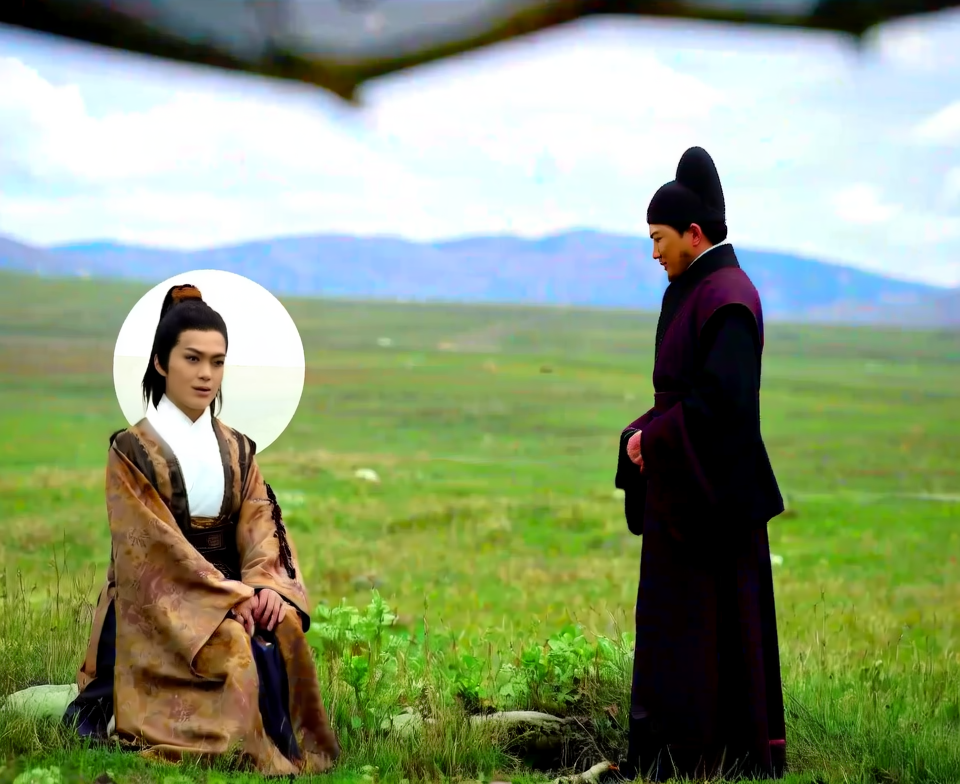

In [19]:
text_kwargs = get_text_preproc(prompt, 
    text_encoder1, text_encoder2, tokenizer1, tokenizer2, 
    entity_prompts=[], device=device)

control_kwargs, control_nps = prepare_control_inputs_for_entity(
    control_image_paths, entity_bboxes, width, height, vae,
    c_width=256, c_height=None, 
    face_entity_bboxes=face_bboxes,
    control_indices=[0], latent_indices=[3], 
    adjust_custom_wh=False, 
    mode="provided_face_bbox",
    # mode="provided_size_mid_x",
    use_rembg=True, print_res=True)

num_inference_steps=25
seed = np.random.randint(2**31)
# seed = 364289299
generator = torch.Generator(device="cpu")
generator.manual_seed(seed)
entitymask_nps = [get_mask_from_bboxes(entity_bboxes, width, height)]
entity_masks = torch.cat([preproc_mask(e_mask, width, height, invert=False)[0] for e_mask in entitymask_nps], 1)

total_kwargs = {
    'prompt': prompt, 'sampler': 'unipc', 'width': width, 'height': height, 'frames': 1, 'batch_size': 1,
    # 'real_guidance_scale': 1.0, 'distilled_guidance_scale': 10.0, 'guidance_rescale': 0.0, 'shift': None,
    'num_inference_step': num_inference_steps, 'generator': generator,
    'device': device, 'dtype': torch.bfloat16,
    'cache_results': True, 'cache_layers': [], 'use_attention_masking': ['mask_control'],
    'entity_masks': entity_masks,
}
attn_cache.clear()
results = sample_hunyuan(transformer=model, **total_kwargs, **text_kwargs, **control_kwargs,)

result_img = Image.fromarray(postproc_imgs(results,vae)[0])
result_img

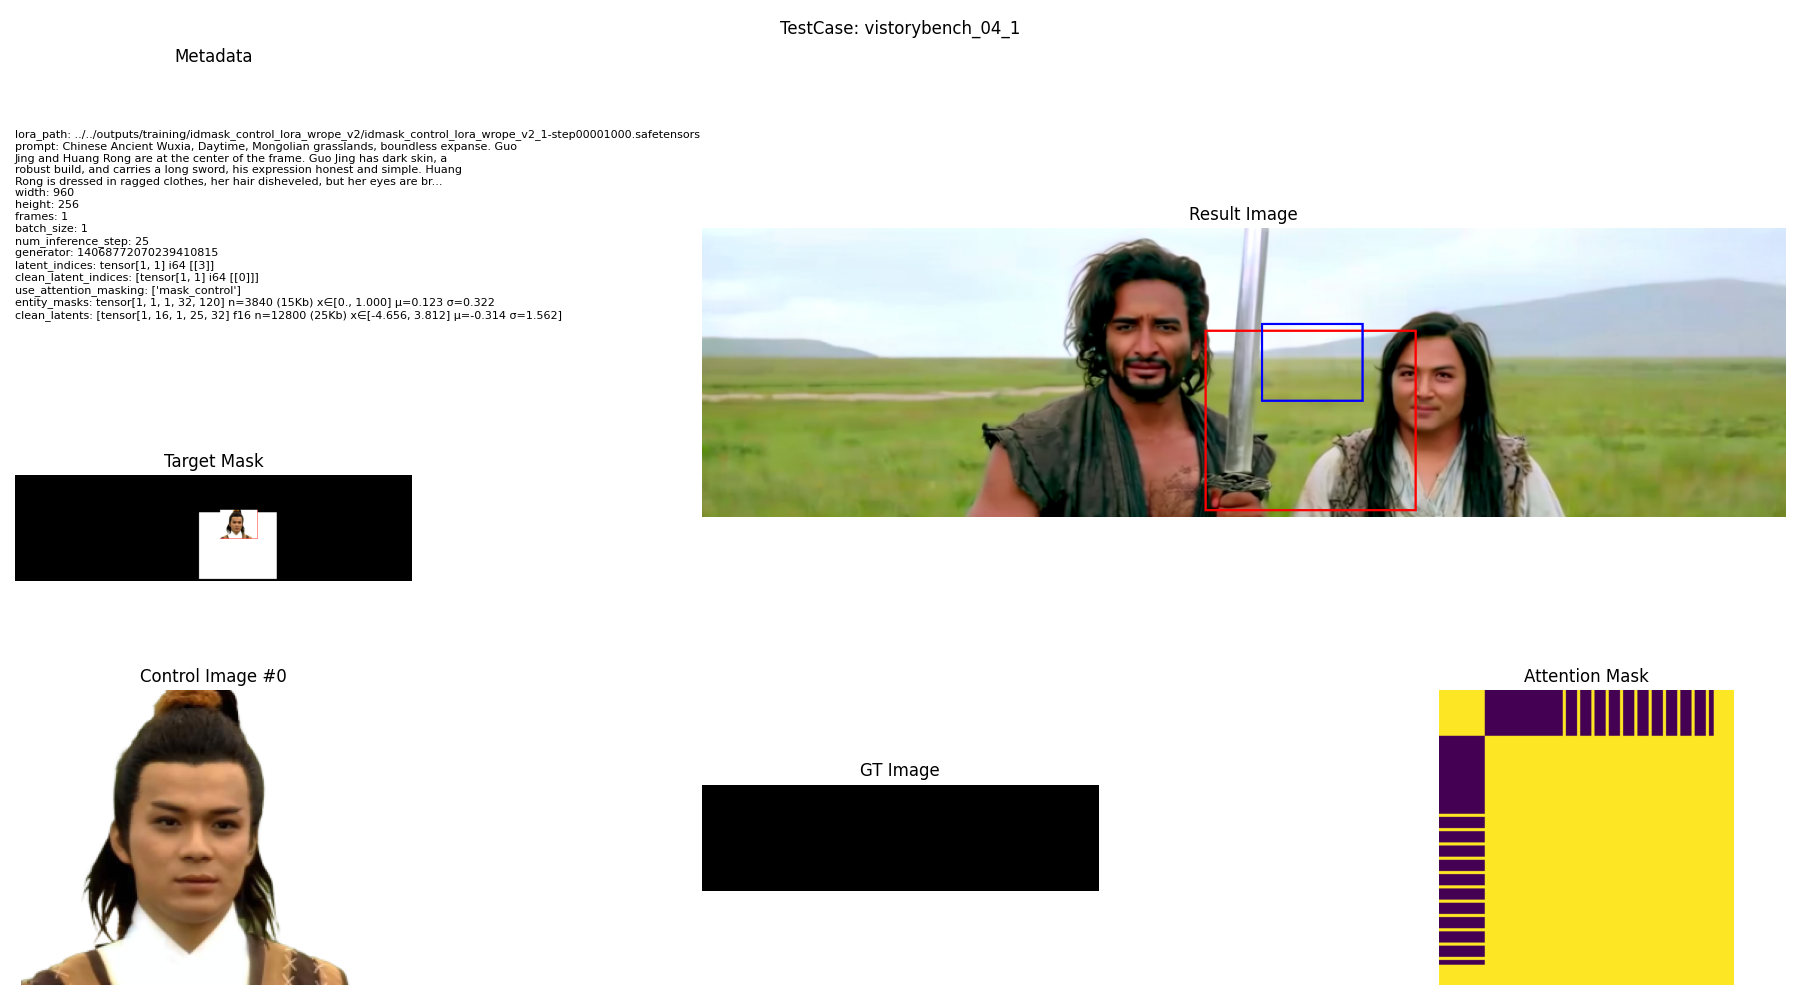

In [13]:
result_img = draw_bboxes(result_img, entity_bboxes)
result_img = draw_bboxes(result_img, control_kwargs['clean_latent_bboxes'].numpy()[0], color=(0,0,255))

mask = Image.fromarray(entitymask_nps[0]).convert("RGB")
for i, clean_latent_bbox in enumerate(control_kwargs['clean_latent_bboxes']):
    mask = draw_bboxes(mask, clean_latent_bbox)
    mask = draw_bboxes_images(mask, clean_latent_bbox, [Image.fromarray(control_nps[i])])

meta_str = printable_metadata(total_kwargs, text_kwargs, control_kwargs, lora_path, maxlen=80)
attn_mask = get_pltplot_as_pil(attn_cache['attn_mask'][0], vmin=-9999., vmax=0., cmap=plt.cm.viridis)
result_img = return_total_visualization(f'vistorybench_{story_num}_{shot_num}', meta_str, np.asarray(result_img), 
                                        attn_mask, control_nps[0], np.asarray(mask), 
                                        np.zeros((height, width, 3), dtype=np.uint8))
result_img